# Breast Cancer Risk score

In [82]:
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from functools import reduce
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [83]:
print(pd.__version__)

0.25.0


## Data Processing

In [84]:
data = pd.read_csv('breastcancer(normalized).csv')

In [85]:
data=data.iloc[:,2:]
data = data.drop(['RaceOther Race - Including Multi-Racial'], axis=1)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 33 columns):
Gender                                 564 non-null int64
NonHispanic_White                      564 non-null int64
NonHispanic_Black                      564 non-null int64
Mexican_American                       564 non-null int64
Other_Hispanic                         564 non-null int64
NonHispanic_Asian                      564 non-null int64
Close_Relative_Heart_Attack            564 non-null int64
Close_Relative_Asthma                  564 non-null int64
Close_Relative_Diabetes                564 non-null int64
Overweight                             564 non-null int64
Lack_Exercise                          564 non-null int64
High_Salt                              564 non-null int64
Hight_Fat_Calories                     564 non-null int64
Alcohol                                564 non-null int64
Smoke                                  564 non-null int64
Had_a_hysterectom        

In [86]:
Y=data['y']
X=data.ix[:,:-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
trainDf = pd.concat([Y_train, X_train], axis=1)
testDf = pd.concat([Y_test, X_test], axis=1)
clasTest = testDf.groupby('y')['y'].count()
print(clasTest)

y
0    161
1      9
Name: y, dtype: int64


The dataset is imbalanced.

## Modeling Process

### Model 1: Logistic Regression Classifier

In [132]:
X=np.asarray(X)
Y=np.asarray(Y)
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, Y, random_state=42, criterion='entropy'):
        X_train_p = X[Y==1]
        X_train_n = X[Y==0]
        Y_train_p = Y[Y==1]
        Y_train_n = Y[Y==0]
        l = sum(Y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            Y_train_f = np.concatenate([Y_train_n[idx_n], Y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, Y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs))
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, Y):
        y_hat = self.predict(X)
        print(classification_report(Y_test, 1.*(y_hat>0.5)))
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

### Model Training

In [133]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, Y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 500 completed.

In [134]:
btc.coefficients() # avg coefficients of n classifiers 

array([[-6.04365212e-06, -3.47726319e-02,  1.88082494e-02,
         1.08801885e-01, -4.43107636e-01,  2.79872971e-01,
         7.23978431e-02,  3.43043447e-01, -4.60888415e-01,
        -1.52257839e-01,  1.95372382e-01,  1.43977894e-01,
         5.44747896e-01, -2.63138808e-01, -1.46699288e-01,
         6.34260341e-01,  7.54457124e-02,  4.87465553e-01,
         3.34610740e-02,  2.45151066e-01,  7.04881941e-02,
        -4.79078757e-02,  8.27543029e-02, -3.00999438e-02,
        -1.61534994e-02, -9.80526002e-03, -2.28416891e-02,
         2.70117922e-02,  3.85055214e-04,  8.64049238e-02,
         6.50975656e-02,  2.66093844e-03]])

### Risk Score of test data

In [135]:

reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(0,len(X_test))
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","NonHispanic_White","NonHispanic_Black", "Mexican_American","Other_Hispanic","NonHispanic_Asian","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","Alcohol","Smoke","Had_a_hysterectom","Had_both_ovaries_removed","Ever_taken_birth_control_pills","Ever_use_female_hormones","Age","BMI","Pulse","AVG_Systolic_Blood_Pressure","AVG_Diastolic_Blood_Pressure","Total_Cholesterol","Atherosclerosis_Index","CReactive_protein","blood_glucose","Age_first_menstrual_period_occurred","Age_last_menstrual_period_occurred","Age_at_first_live_birth","Age_at_last_live_birth","Risk_Score"]
                    
risk_score.head()                 

,Gender,NonHispanic_White,NonHispanic_Black,Mexican_American,Other_Hispanic,NonHispanic_Asian,Close_Relative_Heart_Attack,Close_Relative_Asthma,Close_Relative_Diabetes,Overweight,...,AVG_Diastolic_Blood_Pressure,Total_Cholesterol,Atherosclerosis_Index,CReactive_protein,blood_glucose,Age_first_menstrual_period_occurred,Age_last_menstrual_period_occurred,Age_at_first_live_birth,Age_at_last_live_birth,Risk_Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.283439,0.027197,0.018502,0.007643,0.035032,0.057325,0.216561,0.146497,0.203822,61.437900
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.216561,0.025032,0.018964,0.003822,0.039936,0.101911,0.286624,0.108280,0.133758,47.922896
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.324841,0.039554,0.014983,0.003822,0.036433,0.070064,0.337580,0.108280,0.140127,21.288724
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.398089,0.037197,0.033511,0.011465,0.034268,0.089172,0.324841,0.159236,0.261146,33.501607
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.305732,0.028344,0.021972,0.007006,0.036752,0.076433,0.331210,0.127389,0.242038,55.201105


In [91]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(data[data.columns[2:]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [92]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
16,Ever_taken_birth_control_pills,0.634260
13,Smoke,0.544748
18,Age,0.487466
8,Overweight,0.343043
6,Close_Relative_Asthma,0.279873
20,Pulse,0.245151
11,Hight_Fat_Calories,0.195372
12,Alcohol,0.143978
4,NonHispanic_Asian,0.108802
30,Age_at_last_live_birth,0.086405


### Model Prediction Accuracy

In [93]:
print(classification_report(y_true=Y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.93      0.57      0.70       161
           1       0.03      0.22      0.05         9

    accuracy                           0.55       170
   macro avg       0.48      0.39      0.38       170
weighted avg       0.88      0.55      0.67       170



In [96]:
confusion_matrix(y_true=Y_test, y_pred=y_hat)

array([[91, 70],
       [ 7,  2]])

### Feature Importance

In [97]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

In [98]:
score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
30,Age_at_last_live_birth,13.622943
4,NonHispanic_Asian,17.154137
12,Alcohol,22.700126
11,Hight_Fat_Calories,30.803184
20,Pulse,38.651489
6,Close_Relative_Asthma,44.125882
8,Overweight,54.085590
18,Age,76.855752
13,Smoke,85.887113
16,Ever_taken_birth_control_pills,100.000000


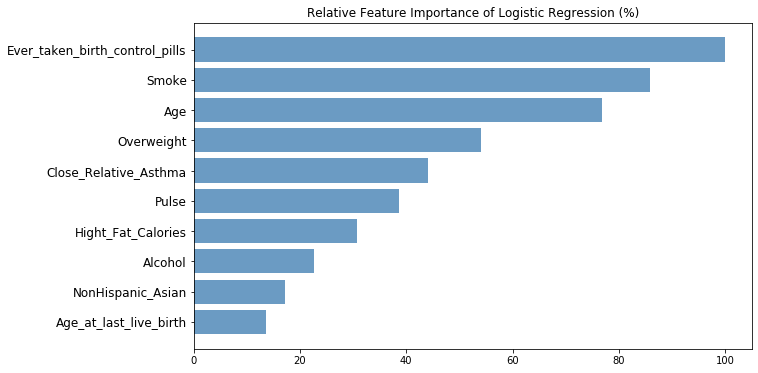

In [99]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

### XGBoost Tree

In [101]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [7]:


# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,Y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma']])


    rank_test_score  mean_test_score param_max_depth param_min_child_weight  \
0                45         0.933628               3                      1   
1                22         0.952566               3                      3   
2                 1         0.960796               3                      5   
3                56         0.928319               5                      1   
4                37         0.948673               5                      3   
5                18         0.960531               5                      5   
6                56         0.928319               7                      1   
7                34         0.948761               7                      3   
8                18         0.960531               7                      5   
9                56         0.928319               9                      1   
10               34         0.948761               9                      3   
11               18         0.960531               9

In [102]:
# use best parameters: max_depth= 7, min_child_weight= 5, gamma=0.2
xgb = XGBClassifier(
 max_depth= 7, 
 min_child_weight= 5,
 gamma=0.2,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))


Training score: 0.9644670050761421
Testing score: 0.9470588235294117


no severe overfitting problems

In [103]:
# confusion matrix
        
pred = xgb.predict(X_test)
confusion_matrix(y_true=Y_test, y_pred=pred)

array([[161,   0],
       [  9,   0]])

In [104]:
print(classification_report(y_true=Y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       161
           1       0.00      0.00      0.00         9

    accuracy                           0.95       170
   macro avg       0.47      0.50      0.49       170
weighted avg       0.90      0.95      0.92       170



# Risk Score

In [105]:
risk_score = 100*xgb.predict_proba(X).reshape(-1,1)



In [106]:

reshaped_X_test = pd.DataFrame(X)
reshaped_X_test.index = np.arange(0,len(X))
reshaped_risk_score = pd.DataFrame(risk_score)

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","NonHispanic_White","NonHispanic_Black", "Mexican_American","Other_Hispanic","NonHispanic_Asian","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","Alcohol","Smoke","Had_a_hysterectom","Had_both_ovaries_removed","Ever_taken_birth_control_pills","Ever_use_female_hormones","Age","BMI","Pulse","AVG_Systolic_Blood_Pressure","AVG_Diastolic_Blood_Pressure","Total_Cholesterol","Atherosclerosis_Index","CReactive_protein","blood_glucose","Age_first_menstrual_period_occurred","Age_last_menstrual_period_occurred","Age_at_first_live_birth","Age_at_last_live_birth","Risk_Score"]

risk_score.head()                

,Gender,NonHispanic_White,NonHispanic_Black,Mexican_American,Other_Hispanic,NonHispanic_Asian,Close_Relative_Heart_Attack,Close_Relative_Asthma,Close_Relative_Diabetes,Overweight,...,AVG_Diastolic_Blood_Pressure,Total_Cholesterol,Atherosclerosis_Index,CReactive_protein,blood_glucose,Age_first_menstrual_period_occurred,Age_last_menstrual_period_occurred,Age_at_first_live_birth,Age_at_last_live_birth,Risk_Score
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.280255,0.031274,0.015482,0.015924,0.037771,0.076433,0.299363,0.222930,0.235669,98.677711
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.343949,0.027834,0.021577,0.014650,0.046115,0.063694,0.242038,0.184713,0.210191,1.322286
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.299363,0.037389,0.033683,0.024841,0.140764,0.101911,0.286624,0.210191,0.242038,97.884521
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.305732,0.022102,0.016744,0.003822,0.034268,0.070064,0.337580,0.121019,0.197452,2.115479
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.277070,0.040000,0.018605,0.008280,0.039236,0.095541,0.299363,0.146497,0.191083,98.082748


## Feature Importance

In [107]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [108]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

## Visualize a single prediction

In [109]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

In [110]:
shap.force_plot(explainer.expected_value, shap_values[:1636,:], X.iloc[:1636,:])

## SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

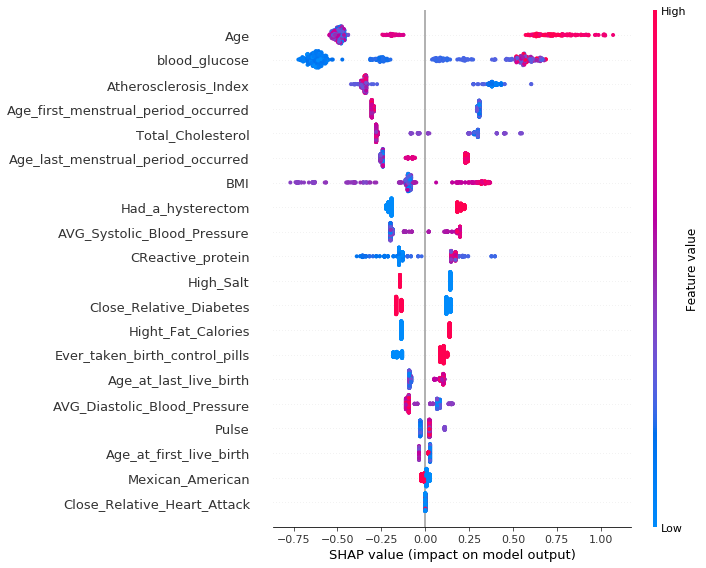

In [111]:
shap.summary_plot(shap_values, X)

## Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

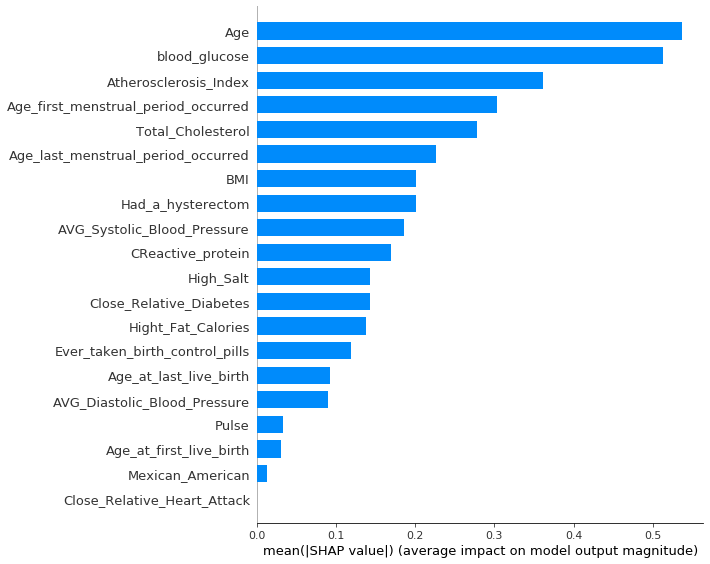

In [112]:
shap.summary_plot(shap_values, X, plot_type="bar")

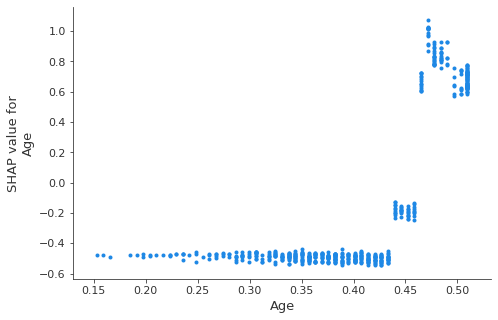

In [113]:
shap.dependence_plot('Age', shap_values, X, interaction_index=None, show=False)